# Determining Effective Average Post Reading Time

In this analysis, we perform outlier removal on a significant sample of post reading time data to enable us obtain an **effective average post reading time** for Taringa! users.

The essence of this is to enable us come up with a good threshold for counting a post read as being significant. It is important because this data point tends to be a very useful input in various ranking analyses.

In [35]:
import pandas as pd
import numpy as np
from typing import List, Union
import seaborn as sns

# Outlier detection and removal is performed in this case using the Inter-quartile Range (IQR) method
# read more about this technique here: https://online.stat.psu.edu/stat200/lesson/3/3.2

# the following IQRComputation class implements the IQR methods and is used for our analysis

class IQRComputation:
    def __init__(self, dataset: Union[List[float], List[int]]) -> None:
        self.dataset = dataset
        self.Q1 = None
        self.Q3 = None
        self.IQR = None
        self.lower_bound = None
        self.upper_bound = None
        self.outliers = []
        self.filtered = []

    def get_percentiles(self):
        if self.dataset:
            self.Q1, self.Q3 = np.percentile(self.dataset, [25, 75])
        return self

    def build_IQR(self):
        if self.Q1 and self.Q3:
            self.IQR = self.Q3 - self.Q1
            self.lower_bound = self.Q1 - 1.5 * self.IQR
            self.upper_bound = self.Q3 + 1.5 * self.IQR
            for i in self.dataset:
                if not (self.lower_bound <= i <= self.upper_bound):
                    self.outliers.append(i)
                else:
                    self.filtered.append(i)
        return self



## Data Source

The dataset contains 18K+ data points of 1,884 Taringa! users reading 2,659 distinct pieces of content (across 10 content types) generated by 526 creators on the platform.

In [36]:
dataset = pd.read_csv("../static/post_reading_times.csv")
dataset.shape

(18473, 8)

In [37]:
dataset[['user_id', 'content_id', 'duration', 'creator', 'FeedType']].head()

user_id                content_id  duration  \
0  646bbe587d05c1fda2c605cb  647765ef844b5fcd2286edc4        10   
1  6467c474681c5e895629e06c  6467b9c6d6472fc4b80ebc3c        59   
2  6451f86c93e9b49222723b56  64596f7341ad499b13d37e27       184   
3  646ae5307d05c1fda2c5e1f6  646ab7fce58ef1ebd17d9d96       149   
4  64714b5e84120c6c2dde69d1  6479520853f79c65c7371380        29   

                    creator    FeedType  
0  644bfaa593e9b49222720378  titleVideo  
1  644ead3793e9b49222721997   textVideo  
2  644bfaa593e9b49222720378  titleVideo  
3  644bfaa593e9b49222720378  titleVideo  
4  645e383aea66584f94f27676  titleVideo

In [38]:
dataset['user_id'].describe()

count                        18154
unique                        1884
top       641b304dbcd2a12b766d3ad5
freq                          1814
Name: user_id, dtype: object

In [39]:
dataset['content_id'].describe()

count                        18473
unique                        2659
top       647cffba243d931e4d911db8
freq                            77
Name: content_id, dtype: object

In [40]:
dataset['creator'].describe()

count                        18303
unique                         526
top       641b304dbcd2a12b766d3ad5
freq                          2206
Name: creator, dtype: object

In [41]:
dataset['FeedType'].describe()

count              18302
unique                10
top       titleTextImage
freq                8845
Name: FeedType, dtype: object

In [42]:
content_types = set(dataset['FeedType'].unique()) - {nan:=np.nan}
content_types

{'image',
 'text',
 'textImage',
 'textVideo',
 'titleImage',
 'titleText',
 'titleTextImage',
 'titleTextVideo',
 'titleVideo',
 'video'}

## Multiple content types - data segmentation

We can see that there are different types of content, so the data would need to be segmented by content type.

<Axes: >

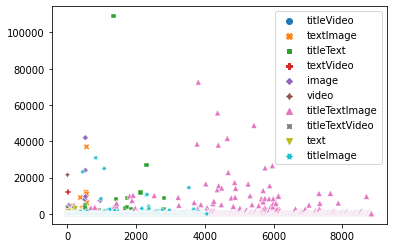

In [43]:
duration_by_content_type = {
    content_type: list(dataset[dataset['FeedType'] == content_type]['duration'].values)
    for content_type in content_types
}

sns.scatterplot(data=duration_by_content_type)

## Data Cleaning

The main data cleaning activity is the detection and removal of outliers (data points that are either too small or too large) from the reading time data, before obtaining the average.

In [44]:
# obtain IQRComputation objects for each content type

iqr_comps = {
    content_type: IQRComputation(dataset=duration_data)
    for content_type, duration_data in duration_by_content_type.items()
}

# run IQR procedure for all content types

iqr_results = {
    content_type: iqr_comp.get_percentiles().build_IQR()
    for content_type, iqr_comp in iqr_comps.items()
}

In [45]:
# count of outliers found
{
    content_type: len(iqr_result.outliers)
    for content_type, iqr_result in iqr_results.items()
}

{'titleVideo': 10,
 'textImage': 99,
 'titleText': 245,
 'textVideo': 2,
 'image': 80,
 'video': 3,
 'titleTextImage': 1009,
 'titleTextVideo': 34,
 'text': 48,
 'titleImage': 415}

In [46]:
# count of valid data found
{
    content_type: len(iqr_result.filtered)
    for content_type, iqr_result in iqr_results.items()
}

{'titleVideo': 81,
 'textImage': 644,
 'titleText': 2571,
 'textVideo': 17,
 'image': 884,
 'video': 20,
 'titleTextImage': 7836,
 'titleTextVideo': 241,
 'text': 418,
 'titleImage': 3645}

<Axes: >

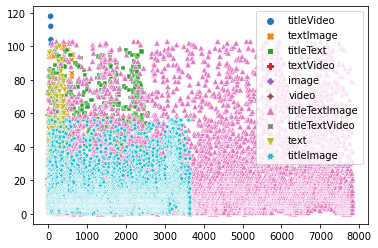

In [47]:
# visualizing the clean dataset
clean_data = {
    content_type: iqr_result.filtered
    for content_type, iqr_result in iqr_results.items()
}
sns.scatterplot(data=clean_data)

## Taking the average duration from clean data by content type



In [48]:
from statistics import mean

average_durations = {
    content_type: mean(iqr_result.filtered)
    for content_type, iqr_result in iqr_results.items()
}

average_durations

{'titleVideo': 27,
 'textImage': 21,
 'titleText': 23,
 'textVideo': 16,
 'image': 13,
 'video': 14,
 'titleTextImage': 23,
 'titleTextVideo': 20,
 'text': 23,
 'titleImage': 14}

In [49]:
min_outliers = {
    content_type: min(iqr_result.outliers)
    for content_type, iqr_result in iqr_results.items()
}
min_outliers

{'titleVideo': 131,
 'textImage': 105,
 'titleText': 99,
 'textVideo': 100,
 'image': 49,
 'video': 70,
 'titleTextImage': 104,
 'titleTextVideo': 101,
 'text': 105,
 'titleImage': 57}

[Text(0, 0, 'titleVideo'),
 Text(1, 0, 'textImage'),
 Text(2, 0, 'titleText'),
 Text(3, 0, 'textVideo'),
 Text(4, 0, 'image'),
 Text(5, 0, 'video'),
 Text(6, 0, 'titleTextImage'),
 Text(7, 0, 'titleTextVideo'),
 Text(8, 0, 'text'),
 Text(9, 0, 'titleImage')]

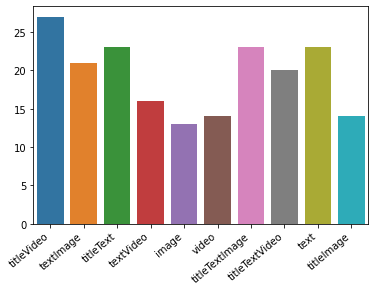

In [50]:
plt = sns.barplot(x=list(average_durations.keys()), y=list(average_durations.values()))
plt.set_xticklabels(plt.get_xticklabels(), rotation=40, ha="right")